# 手写DPO
公式推导https://mp.weixin.qq.com/s/S72LO26IsZ8AED8sQKIWnQ

dpo主要复用ppo里的函数，

dpo的数据格式可以参考llama-factoryhttps://llamafactory.readthedocs.io/zh-cn/latest/getting_started/data_preparation.html#id10

有chosen以及reject，分别对应正样本和负样本

简要总结：

有chosen数据以及reject数据，分别对应正样本和负样本

有ref模型以及actor模型，

ref模型以及actor模型都使用相同的结构，但是参数不同

x1 = actor模型对chosen数据得到log（softmax（logits（chosen数据））） 减去 ref模型对chosen数据得到log（softmax（logits（chosen数据）））

x2 = actor模型对reject数据得到log（softmax（logits（reject数据））） 减去 ref模型对reject数据得到log（softmax（logits（reject数据）））

loss = -F.logsigmoid(beta * （x1 - x2） ) * label

beta是超参数

label代表我们要关注response部分的loss

现在初始ref模型以及actor模型

In [2]:
import torch
from transformers import GPT2Config, GPT2LMHeadModel

torch.manual_seed(1)

# 定义参数
vocab_size = 10
hidden_size = 128
intermediate_size = 256
num_hidden_layers = 2
num_attention_heads = 4

# 加载模型配置
config = GPT2Config(
    vocab_size=50257,
    n_embd=hidden_size,
    n_inner=intermediate_size,
    n_layer=num_hidden_layers,
    n_head=num_attention_heads
)

# 初始化 GPT - 2 模型
model = GPT2LMHeadModel(config)
ref_model = GPT2LMHeadModel(config)
ref_model.eval()

/opt/anaconda3/envs/llm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 128)
    (wpe): Embedding(1024, 128)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-1): 2 x GPT2Block(
        (ln_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=384, nx=128)
          (c_proj): Conv1D(nf=128, nx=128)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=256, nx=128)
          (c_proj): Conv1D(nf=128, nx=256)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=128, out_features=50257, bias=False)
)

## 提取logprobs

In [20]:
import torch.nn.functional as F
import torch

def get_logits(model, inputs):
    # 得到logits
    outputs = model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
    logits = outputs.logits
    return logits


def get_logprobs(model, response_inputs, index_label):
    # 得到logprobs
    logits = get_logits(model, response_inputs)
    # F.log_softmax() 是先进行softmax运算然后再取对数（log）
    all_token_logprobs = F.log_softmax(logits, dim=-1)
    # 使用torch.gather() 从logprobs中收集response的值
    gathered = torch.gather(all_token_logprobs, 2, index_label.unsqueeze(2))
    # 去掉最后一个维度
    response_logprobs = gathered.squeeze(-1)
    return response_logprobs

初始化chosen以及reject

In [21]:
batch_size = 2
length_x = 5
max_new_tokens = 5
prompt = torch.randint(0, vocab_size, (batch_size, length_x))
chosen_response = torch.randint(0, vocab_size, (batch_size, length_x + max_new_tokens))
reject_response = torch.randint(0, vocab_size, (batch_size, length_x + max_new_tokens))
attention_mask = torch.ones(batch_size, length_x+max_new_tokens)
label =  torch.tensor([[0, 0, 0, 0,  0, 1,   1,  1,  1,  1]], dtype=torch.bool)

In [22]:
prompt

tensor([[1, 5, 2, 7, 0],
        [1, 1, 6, 8, 0]])

In [23]:
chosen_response

tensor([[6, 4, 7, 5, 9, 5, 1, 1, 6, 7],
        [9, 3, 1, 1, 3, 2, 0, 9, 9, 8]])

In [24]:
reject_response

tensor([[3, 8, 6, 0, 1, 4, 3, 2, 5, 5],
        [1, 5, 4, 1, 0, 7, 9, 6, 6, 1]])

In [25]:
attention_mask

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [26]:
label

tensor([[False, False, False, False, False,  True,  True,  True,  True,  True]])

In [27]:
x_chosen = {'input_ids':chosen_response, 'attention_mask':attention_mask}
x_rejected = {'input_ids':reject_response, 'attention_mask':attention_mask}

# 计算ref模型和actor模型的logprobs

chosen_response
reject_response

In [28]:
probs_chosen_ref = get_logprobs(ref_model, x_chosen, chosen_response)
probs_chosen = get_logprobs(model, x_chosen, chosen_response)
probs_rejected_ref = get_logprobs(ref_model, x_rejected, reject_response)
probs_rejected = get_logprobs(model, x_rejected, reject_response)

In [29]:
probs_chosen

tensor([[-10.3156,  -9.7152,  -9.6553,  -9.8382,  -9.4010,  -9.5552,  -9.7922,
          -9.7477, -10.0987,  -9.2992],
        [ -9.9923,  -9.9284,  -9.9684,  -9.6602,  -9.6725,  -9.8346,  -9.6949,
          -9.6185,  -9.5147,  -9.8506]], grad_fn=<SqueezeBackward1>)

In [30]:
probs_chosen_ref

tensor([[-10.1076,  -9.9149, -10.0080,  -9.7183,  -9.7094,  -9.5152,  -9.3403,
          -9.7231,  -9.4863,  -9.9287],
        [ -9.8689,  -9.9623,  -9.5794,  -9.6197,  -9.8776,  -9.1791,  -9.5480,
          -9.7149,  -9.6561,  -9.8823]], grad_fn=<SqueezeBackward1>)

## 计算loss

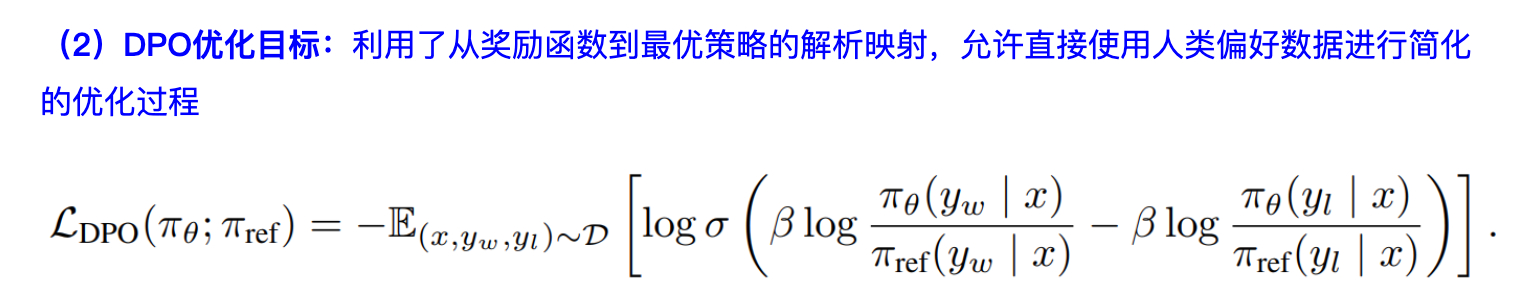

In [33]:
import torch.nn.functional as F

beta = 0.01

x = (probs_chosen - probs_rejected) - (probs_chosen_ref - probs_rejected_ref)
loss = -F.logsigmoid(beta * x ) * label
loss = loss.sum(-1)/attention_mask.sum()
print(loss)

tensor([0.1733, 0.1732], grad_fn=<DivBackward0>)


: 